In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Incorporating lags of the SWN scores and LDA topic scores as predictors in a Dynamic Vector Autoregression (VAR) Model.

So far, we have only considered the same month values of the SWN and LDA scores as exogenous controls in ARIMA models trying to predict the CCI values. However, the latter might be best explained by controlling for lagged values of the explanatory variables. Before including these explicitly in our machine learning models, we test out the value of setting up Vector Autoregression (VAR). 

VAR models are a popular method in time-series econometrics, which estimate all variables as endogenous responses of the lagged values of all the variables. Hence, this system of equations approach is useful in estimating impulse-responses between different variables, capturing potential general equilibrium and dynamic relationships between the variables. Moreover, these models can be set up as to make roll-forward predictions, avoiding potential overfitting. This roll-forward specification for making predictions is called the Dynamic VAR, and we capture the R2 of its predictions as our measurement of the model's predictive quality. 

In this Notebook, we first set up a Dynamic VAR model of the CCI score and the SWN score and evaluate its predictive power. Then, we set up a final Dynamic VAR model with the CCI, SWN and LDA Topics and evaluate its predictive quality. 

## Summary: 
- Roll forward predictions on the last year of CCI data do not improve with either of these models.

## 1) Dynamic VAR - CCI + SWN:

Given that this model works with lagged values as predictors, we see no value in working only with the data of the first 15 days for prediction purposes. Hence, we work with the SWN data for the full month and not just the first two weeks of data. 

In [4]:
# Load Datasets
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
cci = pd.read_csv('Economic_Sentiment_Forecast/CCI.csv', parse_dates=True, index_col='TIME',date_parser=dateparse)
cci = cci["Value"]
cci.columns = ["CCI"]
cci = cci['1990-01-01':]

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df2 = pd.read_csv('./AC209_Project_data/daily_sentiment_1990_2016.csv', parse_dates=True, index_col='date',date_parser=dateparse)
df2 = df2[["avg_score"]]
df2.columns = ["value"]
sen = df2[df2.index.day < 32].resample('MS').mean()
sen.columns = ["SEN"]

df = pd.concat([cci, sen], axis=1)
df.columns = ['CCI', 'SEN']
df = df.ix['1990-01-01':'2016-08-01']

### Test stationarity of CCI and SWN

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax = plt.plot(timeseries, color='blue',label='Original')
    ax = plt.plot(rolmean, color='red', label='Rolling Mean')
    #ax = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #ax = plt.plot(timeseries-rolmean, color='green', label = 'Noise')
    ax = plt.legend(loc='best')
    ax = plt.title('CCI and its Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    for j in ['nc', 'c', 'ct']:
        print ''
        print 'Results of Dickey-Fuller Test (Reg. {}):'.format(j)
        dftest = tsa.adfuller(timeseries, autolag='AIC', regression = j)
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print dfoutput

In [5]:
def is_unit_root(data, threshold="5%"):
    
    nc = tsa.adfuller(data, regression="nc")
    c = tsa.adfuller(data, regression="c")
    ct = tsa.adfuller(data, regression="ct")
    
    votes = 0
    for test in [nc, c, ct]:
        if(abs(test[0]) < abs(test[4][threshold])):
            votes += 1
            
    return votes >= 2, {"nc": nc, "c":c, "ct":ct}

We cannot reject null hypothesis that CCI is Unit Root: 


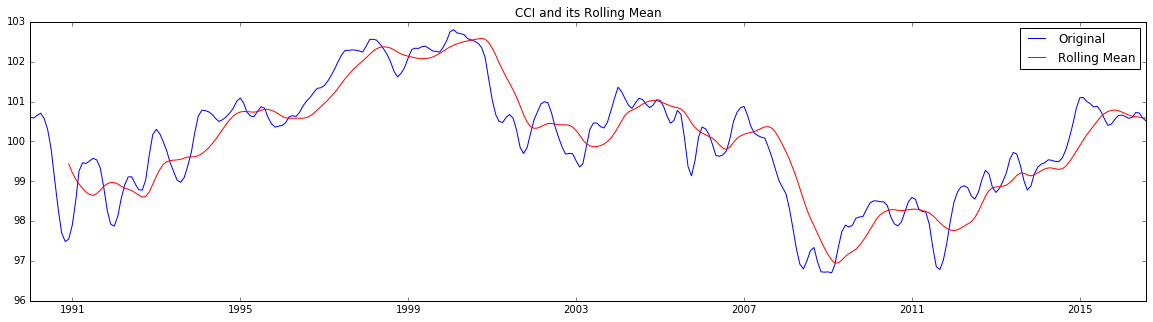


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                   0.031246
p-value                          0.694577
#Lags Used                       4.000000
Number of Observations Used    315.000000
Critical Value (5%)             -1.941886
Critical Value (1%)             -2.572874
Critical Value (10%)            -1.616003
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                  -1.985535
p-value                          0.292951
#Lags Used                       4.000000
Number of Observations Used    315.000000
Critical Value (5%)             -2.870760
Critical Value (1%)             -3.451281
Critical Value (10%)            -2.571682
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                  -2.000069
p-value                          0.601396
#Lags Used                       4.000000
Number of Observations Used    315.000000
Critical Value (5%)             -3.424520
Critical Value (1%)             -3.987801
Criti

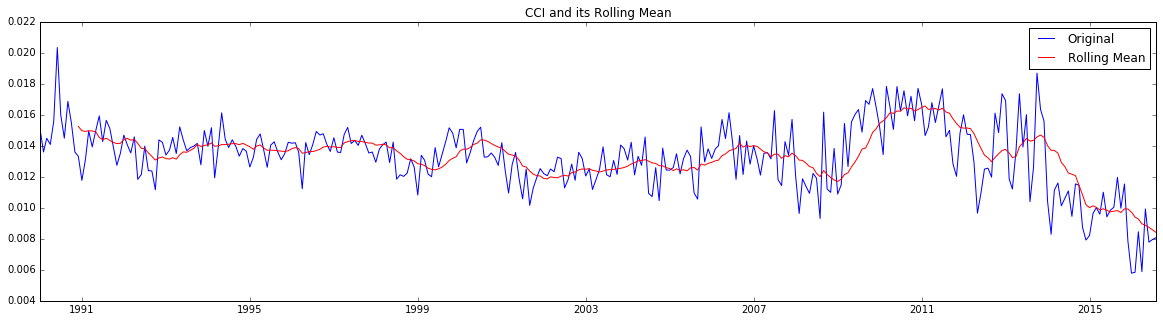


Results of Dickey-Fuller Test (Reg. nc):
Test Statistic                  -1.205740
p-value                          0.208734
#Lags Used                       8.000000
Number of Observations Used    311.000000
Critical Value (5%)             -1.941897
Critical Value (1%)             -2.572967
Critical Value (10%)            -1.615993
dtype: float64

Results of Dickey-Fuller Test (Reg. c):
Test Statistic                  -1.718961
p-value                          0.421370
#Lags Used                       8.000000
Number of Observations Used    311.000000
Critical Value (5%)             -2.870879
Critical Value (1%)             -3.451553
Critical Value (10%)            -2.571746
dtype: float64

Results of Dickey-Fuller Test (Reg. ct):
Test Statistic                  -1.960249
p-value                          0.622909
#Lags Used                       8.000000
Number of Observations Used    311.000000
Critical Value (5%)             -3.424702
Critical Value (1%)             -3.988178
Criti

In [13]:
print 'We cannot reject null hypothesis that CCI is Unit Root: '
test_stationarity(df['CCI'])

print ''
print ''
print 'We cannot reject null hypothesis that SWN is Unit Root: '
test_stationarity(df['SEN'])

Surprisingly, we cannot reject the null hypothesis that the SWN series for the full month follows a random walk, while we were able to confidently do so with the data for the first 15 days. For this reason, we will work with both series in one-month differences for our Dynamic VAR models.

In [14]:
dfs = pd.concat([cci.diff(), sen.diff()], axis=1)
dfs.columns = ['CCI_d', 'SEN_d']
dfs = dfs.ix['1990-01-02':'2016-08-01']

### Lag order specification

In [15]:
# Define application of VAR to relevant dataset
var = tsa.VAR(dfs)

In [16]:
# Select lag order by information criteria
var.select_order(10)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -15.67       -15.65    1.558e-07       -15.67
1        -16.61       -16.54    6.102e-08       -16.58
2        -17.29       -17.17    3.083e-08       -17.25
3        -17.35       -17.18    2.916e-08       -17.28
4        -17.42      -17.20*    2.724e-08       -17.33
5       -17.45*       -17.18   2.640e-08*      -17.34*
6        -17.43       -17.12    2.691e-08       -17.31
7        -17.41       -17.05    2.742e-08       -17.27
8        -17.42       -17.01    2.713e-08       -17.26
9        -17.41       -16.95    2.741e-08       -17.23
10       -17.41       -16.91    2.739e-08       -17.21
* Minimum



{'aic': 5, 'bic': 4, 'fpe': 5, 'hqic': 5}

From the information criteria outlined above for lag order selection, it seems that the most prevalent lag order is 5. Hence, we proceed with the VAR Model with this specification.

### Initial Results

In [19]:
# Fit VAR model with 5 lags (simpler model of those identified)
result = var.fit(5)

In [20]:
print 'Results Summary of the VAR model: '
result.summary()

Results Summary of the VAR model: 


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, Dec, 2016
Time:                     12:08:46
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.1627
Nobs:                     314.000    HQIC:                  -17.3205
Log likelihood:           1866.70    FPE:                2.70554e-08
AIC:                     -17.4254    Det(Omega_mle):     2.52550e-08
--------------------------------------------------------------------
Results for equation CCI_d
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.000485         0.006173           -0.079           0.937
L1.CCI_d         1.452919         0.057779           25.146           0.000
L1.SEN_d       -11.245302         4.103688           -2.740           0.007
L2.C

In [21]:
# Forecasting
lag = result.k_ar
fc = result.forecast(df.values[-lag:], 36)

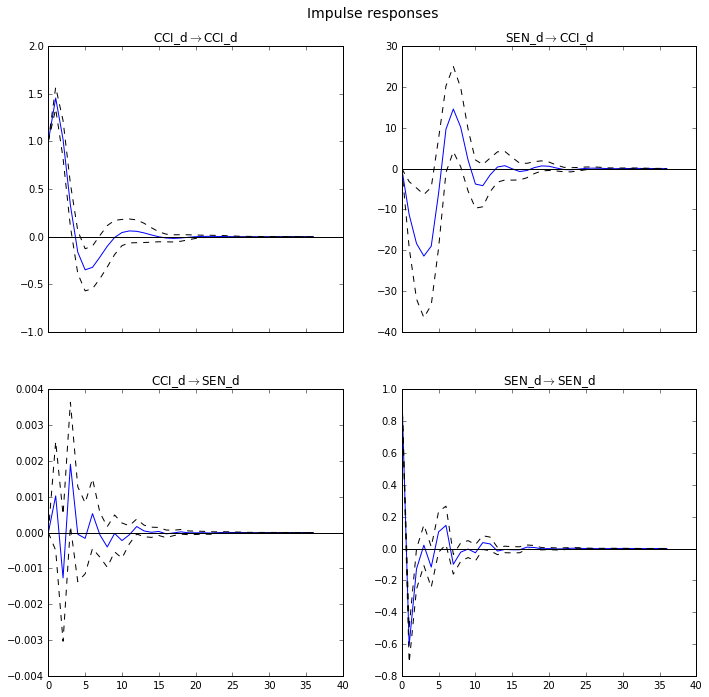

In [22]:
# Impulse Response Function
irf = result.irf(36)
irf.plot()

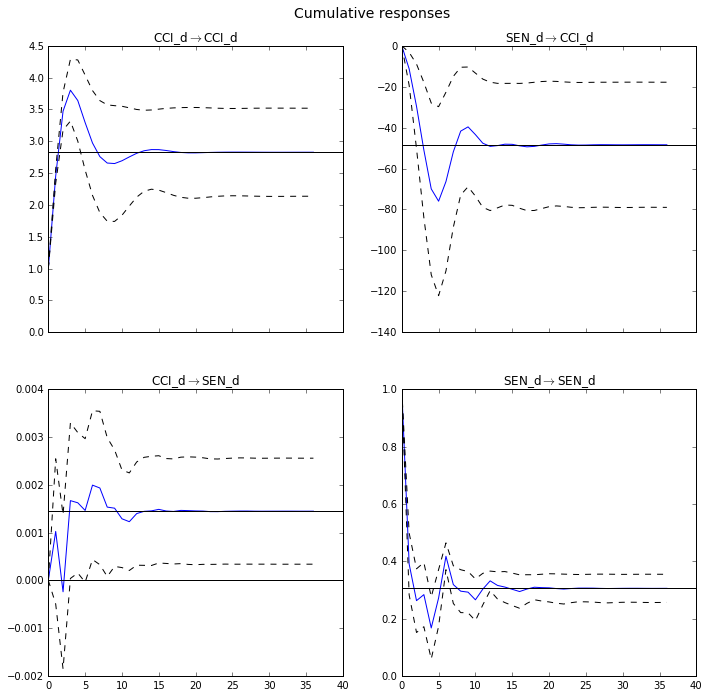

In [268]:
# Cummulative Impulse Response Function
irf.plot_cum_effects(orth=False)

Interestingly, a positive shock on the SWN score is associated with a negative change in the CCI score. There seems to be no statistically significant effect in the inverse direction for the earliest lags, but lags accumulate in a way that a statistically significant effect on the SWN score is noted. 

In [24]:
# Granger Causality
print ''
print 'SEN Granger Causes CCI_d?'
a = result.test_causality('CCI_d', 'SEN_d')

print ''
print 'CCI_d Granger Causes SEN_d?'
a = result.test_causality('SEN_d', 'CCI_d')


SEN Granger Causes CCI_d?
Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         2.752315         2.228893            0.018  (5, 606)
H_0: ['SEN_d'] do not Granger-cause CCI_d
Conclusion: reject H_0 at 5.00% significance level

CCI_d Granger Causes SEN_d?
Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         2.239819         2.228893            0.049  (5, 606)
H_0: ['CCI_d'] do not Granger-cause SEN_d
Conclusion: reject H_0 at 5.00% significance level


The model suggests that both variables 'Granger' cause each other, meaning that the null hypotheses that shocks in one do not affect the other can be confidently rejected. 

### Specifying the Dynamic VAR Model

With the same lag order, we now estimate the rolling-forward models to obtain out of sample predictions. 

In [26]:
# Dynamic Specification of the VAR Model
var = tsa.DynamicVAR(dfs, lag_order=5, window_type='expanding')

In [29]:
print 'Coefficients for each lag in each of the two models: '
var.coefs.major_xs(datetime(2015, 11, 01)).T

Coefficients for each lag in each of the two models: 


,CCI_d,SEN_d
L1.CCI_d,1.454820,0.000989
L1.SEN_d,-11.627700,-0.613813
L2.CCI_d,-1.080201,-0.001955
L2.SEN_d,-9.652587,-0.516154
L3.CCI_d,0.411595,0.003531
L3.SEN_d,-14.541775,-0.367385
L4.CCI_d,-0.112493,-0.002573
L4.SEN_d,-12.574307,-0.366787
L5.CCI_d,0.001520,0.001539
L5.SEN_d,-6.284539,-0.190295


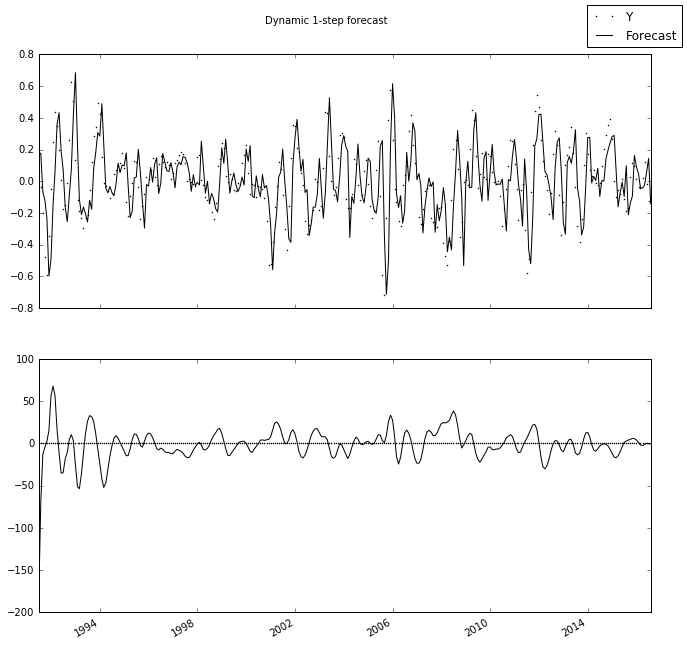

In [30]:
preds = var.forecast(1)
var.plot_forecast(1)

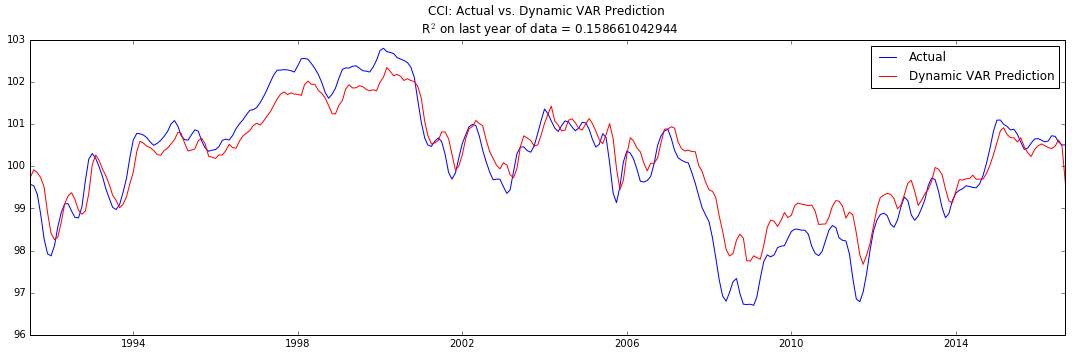

In [39]:
raw_preds = preds['CCI_d']
cci_n = cci['1991-07-01':]
sum_preds = raw_preds.cumsum()
pred = pd.Series(cci_n.ix[0], index=cci_n.index)
pred = pred.add(sum_preds, fill_value=0)

from sklearn.linear_model import LinearRegression as LR
x = np.asarray(pred[-12:]).reshape(12, 1)
y = np.asarray(cci_n[-12:]).reshape(12, 1)
lr = LR().fit(x, y)
a = lr.score(x, y)


plt.figure(figsize = (15,5))
plt.plot(cci_n)
plt.plot(pred, color = 'r')
plt.title('CCI: Actual vs. Dynamic VAR Prediction \n R$^2$ on last year of data = {}'.format(a))
plt.legend(['Actual', 'Dynamic VAR Prediction'], loc='best')
plt.tight_layout()
plt.show()

In contrast to the simple ARIMA and ARIMA + SWN, this model does worse in predicting the last 12 months of CCI data.

## 2) Dynamic VAR - CCI + SWN + LDA Topics: 

We now include the LDA topics into the VAR setting. As was discussed in previous Notebooks, LDA topics are not only non-stationary but they behave with a strong seasonal component. For this reason, we include the 12 month differences of the LDA topics into our VAR model.

In [64]:
# Load datasets
top = np.load('topicsByMonthBigrams8.npy')
top = pd.DataFrame(data = top, index = sen.index)
top.columns = ['T1','T2','T3','T4','T5','T6','T7','T8']

top1 = np.load('topicsByMonthBigrams8.npy')
top1 = pd.DataFrame(data = top1, index = sen.index)
top1.columns = ['T1','T2','T3','T4','T5','T6','T7','T8']
top1 = top1 - top1.shift(12)
top1.dropna(inplace=True)

top2 = np.load('topicsByMonthBigrams8.npy')
top2 = pd.DataFrame(data = top2, index = sen.index)
top2.columns = ['T1','T2','T3','T4','T5','T6','T7','T8']

for i in ['T1','T2','T3','T4','T5','T6','T7','T8']: 
    temp1 = tsa.seasonal_decompose(top2[i].values, freq = 12)
    top2[i] = temp1.trend + temp1.resid
top2.dropna(inplace=True)

dfs = pd.concat([cci, sen], axis = 1)
dfs = dfs - dfs.shift(1)
dfs = pd.concat([dfs, top1], axis = 1)
dfs.dropna(inplace=True)
dfs.columns = ['CCI', 'SEN', 'T1','T2','T3','T4','T5','T6','T7','T8']

### Lag Order Specification

In [65]:
# Define application of VAR to relevant dataset
var = tsa.VAR(dfs)

# Select lag order by information criteria
var.select_order(12)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -39.30       -39.18    8.517e-18       -39.25
1        -41.92       -40.55    6.228e-19       -41.37
2        -43.26      -40.64*    1.642e-19      -42.21*
3        -43.41       -39.55    1.417e-19       -41.86
4        -43.69       -38.59    1.078e-19       -41.65
5        -43.91       -37.57    8.813e-20       -41.37
6        -43.90       -36.31    9.125e-20       -40.86
7        -43.88       -35.05    9.660e-20       -40.34
8        -43.89       -33.81    1.005e-19       -39.85
9        -44.00       -32.68    9.566e-20       -39.47
10       -44.25       -31.69    8.001e-20       -39.23
11       -44.63       -30.83    6.058e-20       -39.10
12      -45.05*       -30.01   4.480e-20*       -39.03
* Minimum



{'aic': 12, 'bic': 2, 'fpe': 12, 'hqic': 2}

We observe 2 information criteria pointing to an optimal lag order of 2, while 2 other information criteria point to an optimal lag order of 12. We opt to select the simpler model with a lag order of 2. Given the very high number of regressors in this specification, we do not show the summary of results, impulse-response and cummulative impulse-response graphs, and other preliminary results to the dynamic VAR specification. 

### Specifying the Dynamic VAR Model

In [72]:
# Dynamic Specification of the VAR Model
var = tsa.DynamicVAR(dfs, lag_order=2, window_type='expanding')
preds = var.forecast(1)

In [73]:
raw_preds = preds['CCI']

cci_n = cci['1993-01-01':]

sum_preds = raw_preds.cumsum()
pred = pd.Series(cci_n.ix[0], index=cci_n.index)
pred = pred.add(sum_preds, fill_value=0)

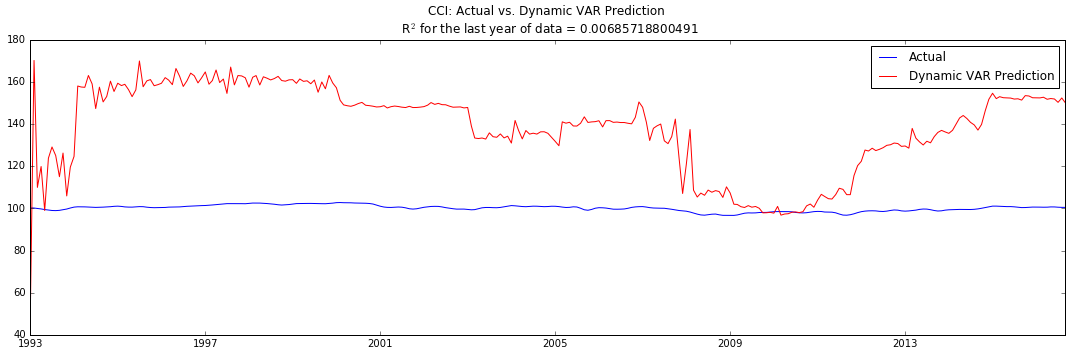

In [74]:
from sklearn.linear_model import LinearRegression as LR
x = np.asarray(pred[-12:]).reshape(12, 1)
y = np.asarray(cci_n[-12:]).reshape(12, 1)
lr = LR().fit(x, y)
a = lr.score(x, y)
plt.figure(figsize = (15,5))
plt.plot(cci_n)
plt.plot(pred, color = 'r')
plt.title('CCI: Actual vs. Dynamic VAR Prediction \n R$^2$ for the last year of data = {}'.format(a))
plt.legend(['Actual', 'Dynamic VAR Prediction'], loc='best')
plt.tight_layout()
plt.show()

The roll-forward R2 score for the last 12 months of data suggests that the resulting predictions are only marginally better than average CCI values. 

## 3) Conclusions:
These results suggest that we should not proceed with VAR style specifications, as roll-forward predictions for the last year of data coming from other simpler models outperform both VAR specifications. This however, does not rule out lagged values of the regressors a possible controls that can help improve predictions on current CCI values. In order to control for these possible effects, we proceed now into specifying new machine-learning models that use lags of SWN and LDA topics, along with their current values, as regressors for current values of CCI as unique response.